In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

#from fastrenewables.gan.core import get_dataloaders
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
from fastrenewables.gan.model import *
import glob

In [3]:
# export

class DummyDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=1000, n_cat_feats=10, n_cont_feats=10):

        self.n_samples = n_samples
        self.cat_data = torch.randn(n_cat_feats, n_samples)
        self.cont_data = torch.randn(n_cont_feats, n_samples)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x_cat = self.cat_data[:, idx]
        x_cont = self.cont_data[:, idx]
        return x_cat, x_cont

class W_Gan(nn.Module):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, clip=0.001):
        super(W_Gan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.clip = clip
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, z, x_cat, x_cont):
        # train the generator model
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(x_cat, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, z, x_cat, x_cont):
        # train the discriminator model
        self.discriminator.zero_grad()
        y_real = self.discriminator(x_cat, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(z, z).detach()
        y_fake = self.discriminator(x_cat, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

class GanLearner():
    def __init__(self, gan, device='cpu'):
        super(GanLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.device = device
        
    def to_device(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device=device
        self.gan.generator = self.gan.generator.to(torch.device(device))
        self.gan.discriminator = self.gan.discriminator.to(torch.device(device))
        
    def noise(self, x, n_z=100):
        z = torch.randn(x.shape[0], n_z).to(self.device)
        return z
    
    def generate_samples(self, x):
        z = self.noise(x)
        fake_samples = self.gan.generator(z, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, n_gen=1, n_dis=1, plot_epochs=10):
        # train gan and store parameters and losses in given class
        self.to_device()
        
        for e in tqdm(range(epochs)):
            
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                #x_cat = None
                
                for _ in range(n_dis):
                    z = self.noise(x_cont)
                    self.gan.train_discriminator(z, x_cat, x_cont)

                for _ in range(n_gen):
                    z = self.noise(x_cont)
                    self.gan.train_generator(z, x_cat, x_cont)
                break
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
                
        self.to_device('cpu')        
        return

In [4]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m',
       'SinWindDirection60m', 'CosWindDirection60m', 'WindSpeed58mMinus_t_1',
       'SinWindDirection58mMinus_t_1', 'CosWindDirection58mMinus_t_1',
       'WindSpeed60mMinus_t_1', 'SinWindDirection60mMinus_t_1',
       'CosWindDirection60mMinus_t_1', 'WindSpeed58mPlus_t_1',
       'SinWindDirection58mPlus_t_1', 'CosWindDirection58mPlus_t_1',
       'WindSpeed60mPlus_t_1', 'SinWindDirection60mPlus_t_1',
       'CosWindDirection60mPlus_t_1']
cat_names = ['TaskID', 'Month', 'Day', 'Hour']

dls = RenewableDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                      y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, 
                                      cont_names=cont_names)

In [5]:
dl = dls.train
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    break
n_cont_feats = x_cont.shape[1]
gen_structure = [100, 500, n_cont_feats]
dis_structure = [n_cont_feats, 500, 1]
generator = GANMLP(gen_structure)
discriminator = GANMLP(dis_structure)
gen_optim = torch.optim.RMSprop(generator.parameters())
dis_optim = torch.optim.RMSprop(discriminator.parameters())
gan = W_Gan(generator, discriminator, gen_optim, dis_optim)
learn = GanLearner(gan)

torch.Size([64, 4]) torch.Size([64, 23]) torch.Size([64, 1])


 94%|█████████▍| 94/100 [00:01<00:00, 79.74it/s]

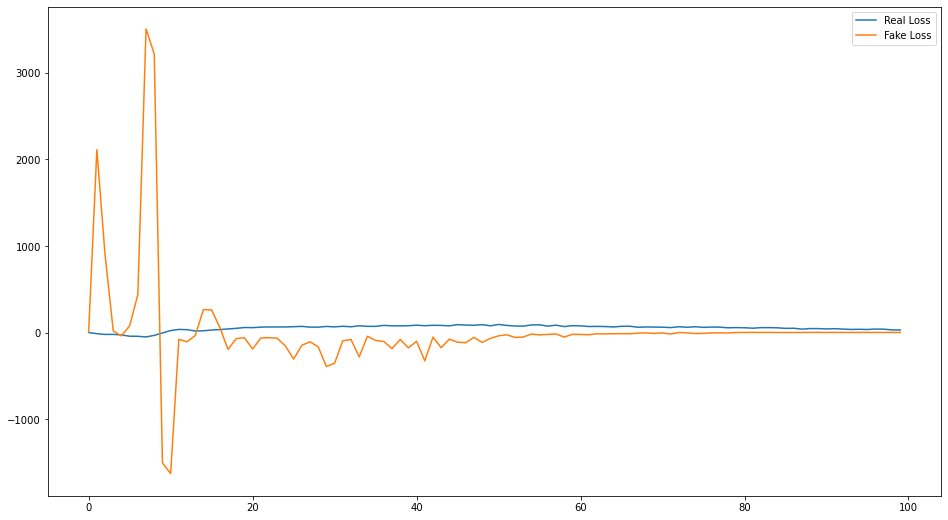

100%|██████████| 100/100 [00:01<00:00, 69.64it/s]


In [6]:
learn.fit(dl, 100, plot_epochs=100)

In [7]:
learn.device = 'cpu'

x_real = x_cont.reshape(1, -1)
x_fake = learn.generate_samples(x_cont).reshape(1, -1)

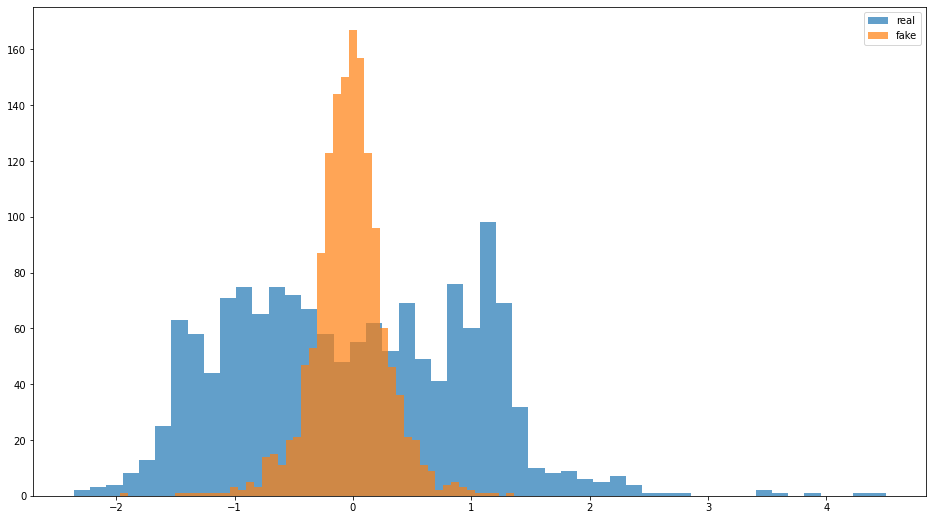

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.hist(x_real, bins=50, label='real', alpha=0.7)
plt.hist(x_fake, bins=50, label='fake', alpha=0.7)
plt.legend()
plt.show()